<a href="https://colab.research.google.com/github/Abinayaa1006/Netflix-Analysis/blob/main/NETFLIX_PROJECT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any necessary packages (like wordcloud for an optional bonus task)
!pip install -q pandas matplotlib seaborn plotly wordcloud

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set visual style for charts
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
from google.colab import files
uploaded = files.upload()

# Load the dataset into a DataFrame
import io
file_name = list(uploaded.keys())[0] # Gets the name of your uploaded file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Show basic info
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}") # Shows (number of rows, number of columns)
print("\nFirst look at the data:")
print(df.head())

Saving netflix_titles.csv to netflix_titles.csv
Dataset loaded successfully!
Shape: (8807, 12)

First look at the data:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021  

In [3]:
# Initial Data Check
print("=== STEP 1: INITIAL DATA CHECK ===")
print(f"Dataset Shape: {df.shape} rows, {df.shape[1]} columns")
print("\n--- Column Data Types ---")
print(df.dtypes)
print("\n--- First Look at Missing Values ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Show only columns with missing data
print("\n--- Sample of Problematic 'duration' Column ---")
print(df[['type', 'duration']].head(10))

=== STEP 1: INITIAL DATA CHECK ===
Dataset Shape: (8807, 12) rows, 12 columns

--- Column Data Types ---
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

--- First Look at Missing Values ---
director      2634
cast           825
country        831
date_added      10
rating           4
duration         3
dtype: int64

--- Sample of Problematic 'duration' Column ---
      type   duration
0    Movie     90 min
1  TV Show  2 Seasons
2  TV Show   1 Season
3  TV Show   1 Season
4  TV Show  2 Seasons
5  TV Show   1 Season
6    Movie     91 min
7    Movie    125 min
8  TV Show  9 Seasons
9    Movie    104 min


In [4]:
# Handle Missing Data
print("=== STEP 2: HANDLING MISSING DATA ===")

# 1. Drop less important columns if they have too many missing values (like 'director')
# We'll fill others with placeholders.
df_clean = df.copy()

# Fill missing text fields with 'Unknown'
text_columns_to_fill = ['director', 'cast', 'country', 'rating']
for col in text_columns_to_fill:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna('Unknown')
        missing_before = df[col].isnull().sum()
        missing_after = df_clean[col].isnull().sum()
        print(f"Filled {missing_before} missing values in '{col}'.")

# For 'date_added', we might want to drop rows if analysis is time-based,
# or fill with a placeholder. Let's just drop for simplicity in a date analysis.
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['date_added'])
rows_after = len(df_clean)
print(f"\nDropped {rows_before - rows_after} rows with missing 'date_added'.")

print(f"\n--- Missing Values After Cleaning ---")
print(df_clean.isnull().sum().sum(), "total missing values remaining.")

=== STEP 2: HANDLING MISSING DATA ===
Filled 2634 missing values in 'director'.
Filled 825 missing values in 'cast'.
Filled 831 missing values in 'country'.
Filled 4 missing values in 'rating'.

Dropped 10 rows with missing 'date_added'.

--- Missing Values After Cleaning ---
3 total missing values remaining.


In [5]:
# Fix Data Types and Formatting
print("=== STEP 3: FIXING DATA TYPES AND FORMATTING ===")

# 1. Clean 'date_added' column: remove leading/trailing whitespace first
df_clean['date_added'] = df_clean['date_added'].str.strip()
print("✅ Stripped whitespace from 'date_added'.")

# 2. Now convert to datetime with flexible parsing
df_clean['date_added'] = pd.to_datetime(df_clean['date_added'], errors='coerce', format='mixed')
print(f"✅ Converted 'date_added' to datetime. {df_clean['date_added'].isna().sum()} dates failed to parse.")

# 3. Extract year and month from successfully parsed dates
df_clean['year_added'] = df_clean['date_added'].dt.year
df_clean['month_added'] = df_clean['date_added'].dt.month_name()
print("✅ Extracted 'year_added' and 'month_added'.")

# 4. Fix the 'duration' column issue
print("\n--- Handling 'duration' Column ---")
def split_duration(row):
    try:
        if pd.isna(row['duration']):
            return pd.Series([None, None])
        if row['type'] == 'Movie':
            # Extract numbers from strings like "90 min"
            num_part = str(row['duration']).split()[0]
            return pd.Series([int(num_part) if num_part.isdigit() else None, None])
        else:  # TV Show
            # Extract numbers from strings like "2 Seasons"
            num_part = str(row['duration']).split()[0]
            return pd.Series([None, int(num_part) if num_part.isdigit() else None])
    except Exception as e:
        # If anything goes wrong, return None values
        return pd.Series([None, None])

# Apply the function
df_clean[['movie_duration_min', 'show_num_seasons']] = df_clean.apply(split_duration, axis=1)
print(f"✅ Split 'duration' column:")
print(f"   - {df_clean['movie_duration_min'].notna().sum()} movies have duration in minutes")
print(f"   - {df_clean['show_num_seasons'].notna().sum()} TV shows have season count")

# 5. Handle the 'listed_in' (genres) column
df_clean['genres_list'] = df_clean['listed_in'].str.split(', ')

print("\n--- New/Updated Columns Preview ---")
print(df_clean[['type', 'date_added', 'duration', 'movie_duration_min', 'show_num_seasons', 'genres_list']].head(10))

=== STEP 3: FIXING DATA TYPES AND FORMATTING ===
✅ Stripped whitespace from 'date_added'.
✅ Converted 'date_added' to datetime. 0 dates failed to parse.
✅ Extracted 'year_added' and 'month_added'.

--- Handling 'duration' Column ---
✅ Split 'duration' column:
   - 6128 movies have duration in minutes
   - 2666 TV shows have season count

--- New/Updated Columns Preview ---
      type date_added   duration  movie_duration_min  show_num_seasons  \
0    Movie 2021-09-25     90 min                90.0               NaN   
1  TV Show 2021-09-24  2 Seasons                 NaN               2.0   
2  TV Show 2021-09-24   1 Season                 NaN               1.0   
3  TV Show 2021-09-24   1 Season                 NaN               1.0   
4  TV Show 2021-09-24  2 Seasons                 NaN               2.0   
5  TV Show 2021-09-24   1 Season                 NaN               1.0   
6    Movie 2021-09-24     91 min                91.0               NaN   
7    Movie 2021-09-24    125 min

In [6]:
# Clean Complex Columns
print("=== STEP 4: CLEANING COMPLEX COLUMNS ===")

# 1. The 'country' column often has multiple entries like "United States, India, United Kingdom"
# We'll keep only the first (primary) country for simpler analysis.
df_clean['primary_country'] = df_clean['country'].str.split(',').str[0].str.strip()
print("✅ Extracted 'primary_country' (first country listed).")

# 2. Standardize text in 'rating' by stripping whitespace (some might have extra spaces)
df_clean['rating'] = df_clean['rating'].str.strip()
print("✅ Stripped whitespace from 'rating' column.")

# 3. Clean 'cast': similar to country, we'll just take the first listed actor for a "main star" analysis.
df_clean['main_cast'] = df_clean['cast'].str.split(',').str[0].str.strip()
print("✅ Extracted 'main_cast' (first actor listed).")

print(f"\n--- Cleaned Data Shape ---")
print(df_clean.shape)

=== STEP 4: CLEANING COMPLEX COLUMNS ===
✅ Extracted 'primary_country' (first country listed).
✅ Stripped whitespace from 'rating' column.
✅ Extracted 'main_cast' (first actor listed).

--- Cleaned Data Shape ---
(8797, 19)


In [7]:
# Final Verification
print("=== STEP 5: FINAL VERIFICATION ===")
print("\n--- Cleaned Dataset Info ---")
print(df_clean.info())

print("\n--- Sample of Cleaned Data ---")
print(df_clean[['type', 'primary_country', 'rating', 'movie_duration_min', 'show_num_seasons']].head(10))

print("\n--- Summary Statistics for New Numeric Columns ---")
print(df_clean[['movie_duration_min', 'show_num_seasons']].describe())

# Save the cleaned dataframe to a new CSV if you want to use it later
df_clean.to_csv('netflix_titles_cleaned.csv', index=False)
print("\n✅ Data cleaning complete! Cleaned dataset saved as 'netflix_titles_cleaned.csv'.")
print("🎯 You are now ready for efficient analysis!")

=== STEP 5: FINAL VERIFICATION ===

--- Cleaned Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 8797 entries, 0 to 8806
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   show_id             8797 non-null   object        
 1   type                8797 non-null   object        
 2   title               8797 non-null   object        
 3   director            8797 non-null   object        
 4   cast                8797 non-null   object        
 5   country             8797 non-null   object        
 6   date_added          8797 non-null   datetime64[ns]
 7   release_year        8797 non-null   int64         
 8   rating              8797 non-null   object        
 9   duration            8794 non-null   object        
 10  listed_in           8797 non-null   object        
 11  description         8797 non-null   object        
 12  year_added          8797 non-null   int32   

--- QUESTION 1: Data Overview ---
Total titles in the dataset: 8807

Number of Movies: 6131
Number of TV Shows: 2676


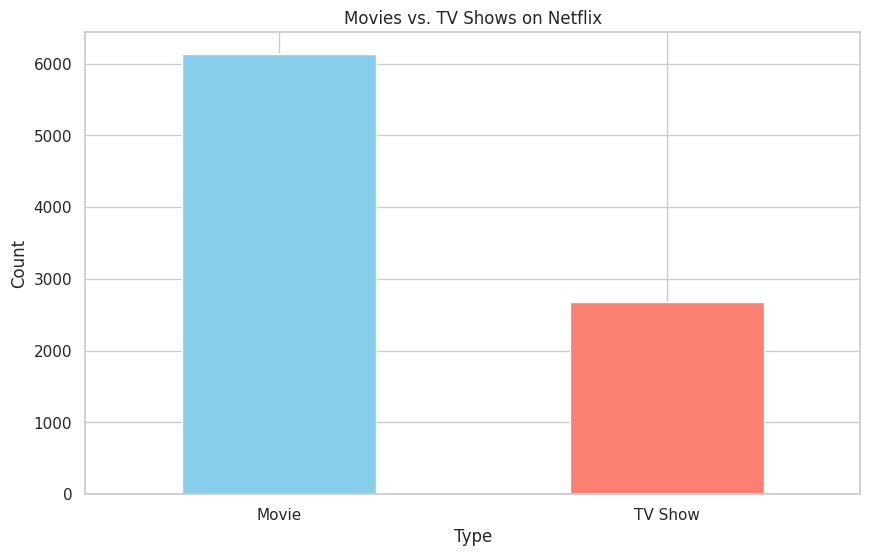

In [8]:
print("--- QUESTION 1: Data Overview ---")
print(f"Total titles in the dataset: {len(df)}")

# Count of Movies vs. TV Shows
type_counts = df['type'].value_counts()
print(f"\nNumber of Movies: {type_counts.get('Movie', 0)}")
print(f"Number of TV Shows: {type_counts.get('TV Show', 0)}")

# Simple visualization
type_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Movies vs. TV Shows on Netflix')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

--- QUESTION 2: Content Trends Over Time ---


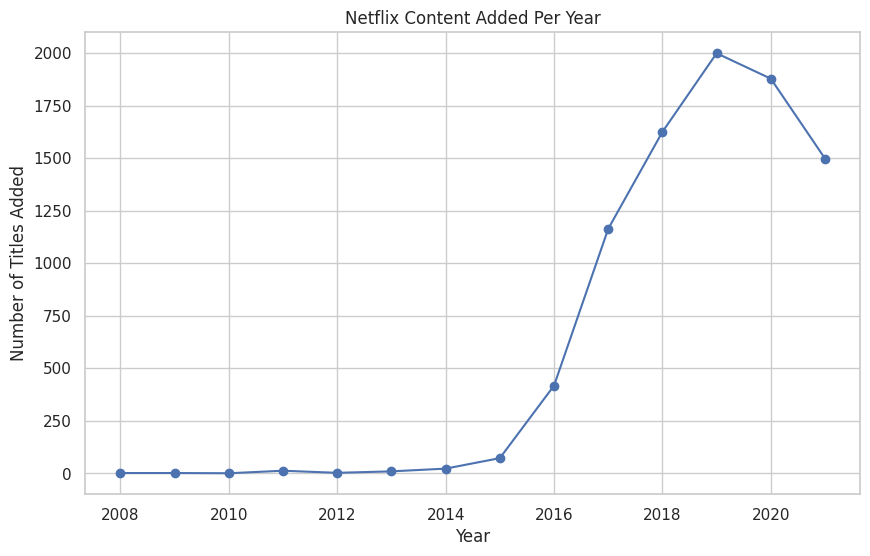

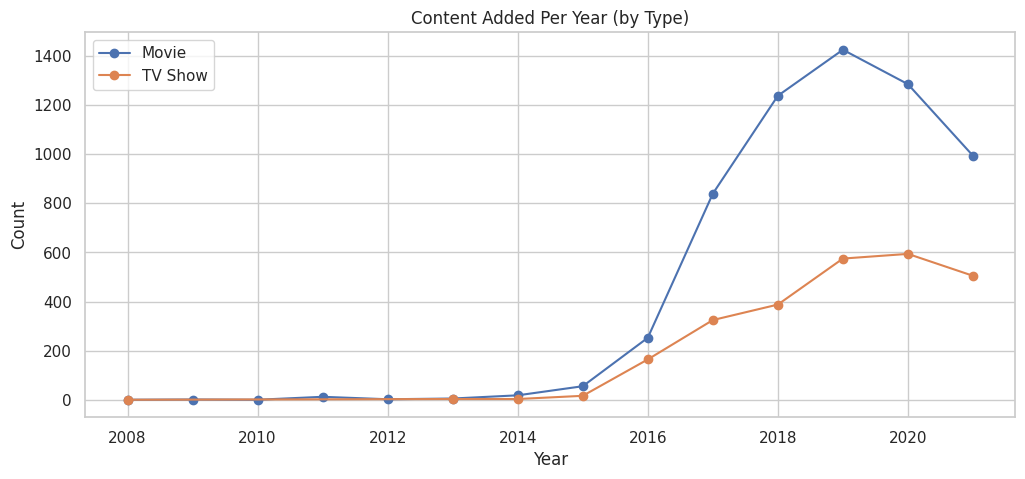

In [9]:
print("--- QUESTION 2: Content Trends Over Time ---")

# Convert 'date_added' to datetime and extract the year
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year

# Count titles added per year
additions_per_year = df['year_added'].value_counts().sort_index()

# Plot the trend
plt.plot(additions_per_year.index, additions_per_year.values, marker='o')
plt.title('Netflix Content Added Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles Added')
plt.grid(True)
plt.show()

# Optional: Separate trend for Movies and TV Shows
plt.figure(figsize=(12, 5))
for content_type in ['Movie', 'TV Show']:
    subset = df[df['type'] == content_type]
    trend = subset['year_added'].value_counts().sort_index()
    plt.plot(trend.index, trend.values, marker='o', label=content_type)

plt.title('Content Added Per Year (by Type)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

--- QUESTION 3: Which countries produce the most Netflix content? ---

Top 10 Content-Producing Countries:
primary_country
United States     3211
India             1008
United Kingdom     628
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Australia          117


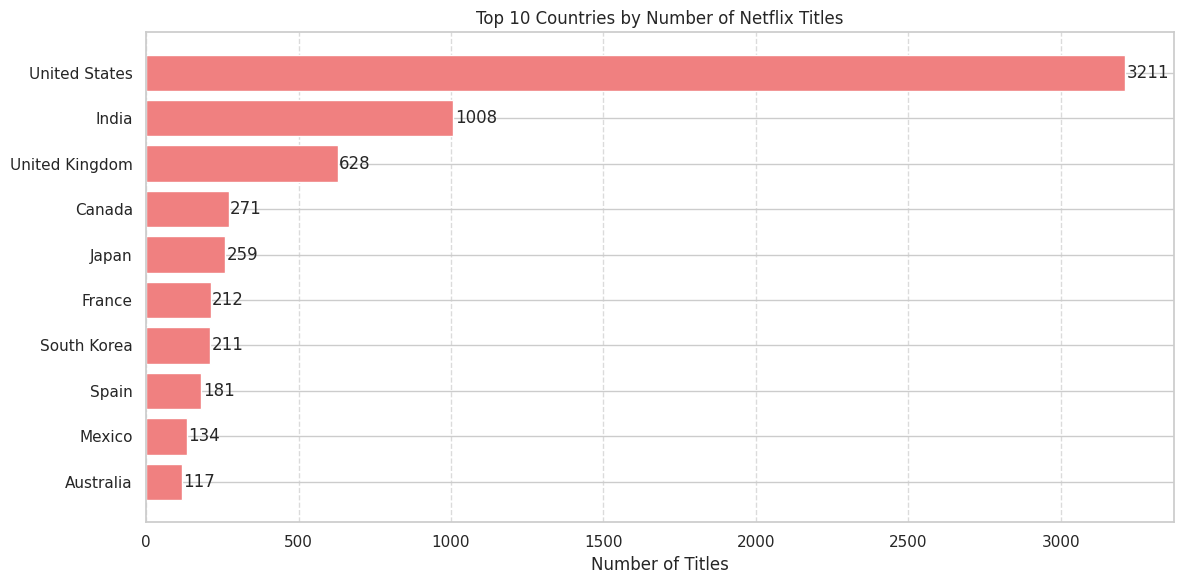


Note: 831 entries (9.4%) have no country data.


In [10]:
print("--- QUESTION 3: Which countries produce the most Netflix content? ---\n")

# 1. Check and clean the 'country' column (some entries have multiple countries separated by commas)
# We'll take the first listed country as the primary one.
df['primary_country'] = df['country'].str.split(',').str[0].str.strip()

# 2. Count titles by primary country, get the top 10
top_countries = df['primary_country'].value_counts().head(10)

print("Top 10 Content-Producing Countries:")
print(top_countries.to_string())

# 3. Create a bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(top_countries.index, top_countries.values, color='lightcoral')
plt.gca().invert_yaxis() # Display the highest count at the top
plt.title('Top 10 Countries by Number of Netflix Titles')
plt.xlabel('Number of Titles')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the count numbers to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

plt.tight_layout()
plt.show()

# 4. Bonus: Check for missing values
missing_country_pct = (df['country'].isna().sum() / len(df)) * 100
print(f"\nNote: {df['country'].isna().sum():,} entries ({missing_country_pct:.1f}%) have no country data.")

--- QUESTION 4: What are the most common content ratings? ---

All Content Ratings (Sorted by Frequency):
rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1


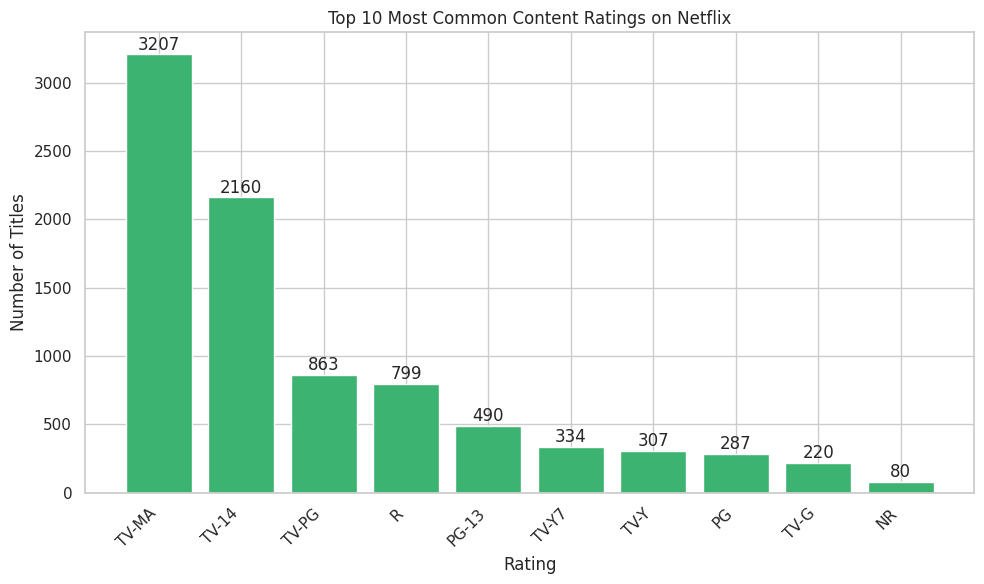


--- Rating Distribution by Type (Top 5 Ratings for Each) ---


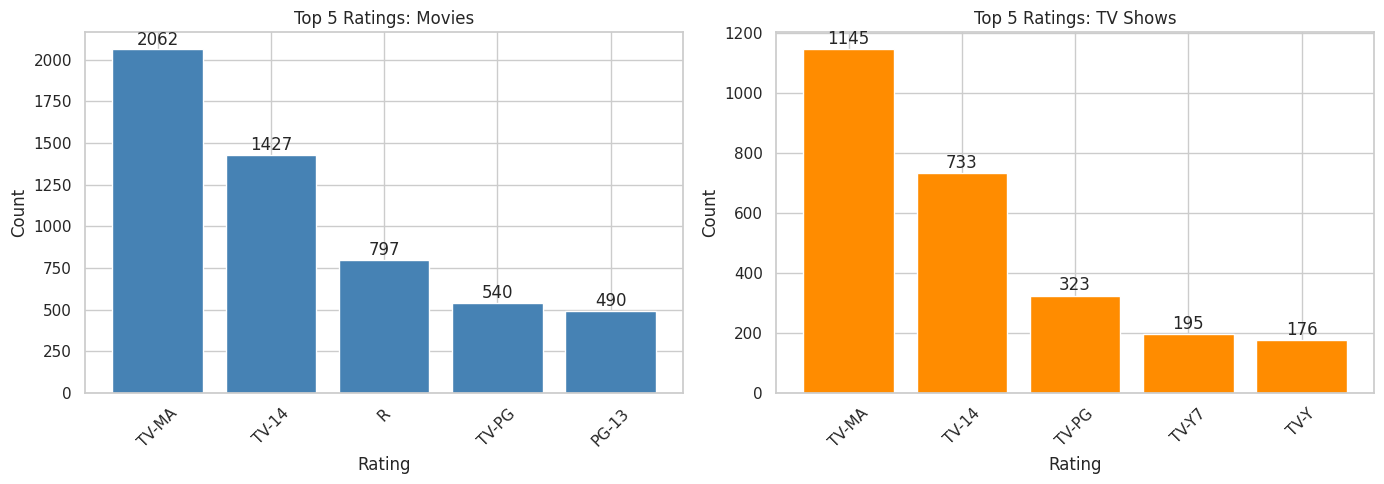

In [11]:
print("--- QUESTION 4: What are the most common content ratings? ---\n")

# 1. Count the ratings
rating_counts = df['rating'].value_counts()

print("All Content Ratings (Sorted by Frequency):")
print(rating_counts.to_string())

# 2. Plot the top 10 ratings
top_ratings = rating_counts.head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_ratings.index, top_ratings.values, color='mediumseagreen')
plt.title('Top 10 Most Common Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. Compare ratings for Movies vs. TV Shows
print("\n--- Rating Distribution by Type (Top 5 Ratings for Each) ---")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, content_type in enumerate(['Movie', 'TV Show']):
    subset = df[df['type'] == content_type]
    type_ratings = subset['rating'].value_counts().head(5)

    axes[i].bar(type_ratings.index, type_ratings.values, color='steelblue' if i==0 else 'darkorange')
    axes[i].set_title(f'Top 5 Ratings: {content_type}s')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    # Add labels
    for bar in axes[i].patches:
        axes[i].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                    f'{int(bar.get_height())}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
files.download('netflix_titles_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>